In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
#!pip3 install monai

In [3]:
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import monai
import nibabel as nib
import matplotlib.pyplot as plt
import os

In [4]:
sys.path.insert(0,"../../")
import models
import glob

In [5]:
sys.path.insert(0,"../../../latentshift/captum")
import captum

sys.path.insert(0,"/home/users/joecohen/workspace/latentshift")
import video_utils

In [6]:
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=1)

# Load the model from a file
MODEL_FILE = 'ct_diabetes_prediction_5yr_best.pt'
model.load_state_dict(torch.load(MODEL_FILE, map_location='cpu'))

<All keys matched successfully>

In [7]:
def preprocess(img_path):
    """
    Preprocesses the image and returns a tensor
    """
    # Load the image
    nifti_img = nib.load(img_path)
    img_data = np.array(nifti_img.dataobj, dtype=np.float32)

    # Scale the image values
    img_data = img_data / 1024.0

    # take every other slice in the z direction, in the case where the image spacing is originally 1.5mm in the z direction
    img_data = img_data[:, :, ::2]

    # Define the target size
    target_size = [248, 248, 150]

    # Check if padding is needed
    if np.any(np.array(img_data.shape) < target_size):
        pad_width = [(0, max_size - img_size) if img_size < max_size else (0, 0) for img_size, max_size in zip(img_data.shape, target_size)]
        img_data = np.pad(img_data, pad_width, mode='constant')

    # Check if cropping is needed
    if np.any(np.array(img_data.shape) > target_size):
        crop_width = [(img_size - max_size) // 2 if img_size > max_size else 0 for img_size, max_size in zip(img_data.shape, target_size)]
        img_data = img_data[crop_width[0]:crop_width[0]+target_size[0], crop_width[1]:crop_width[1]+target_size[1], crop_width[2]:crop_width[2]+target_size[2]]

    # Add batch dimension and the channel dimension
    img_data = img_data[np.newaxis, np.newaxis, :, :, :]

    # Convert to tensor
    img_data = torch.from_numpy(img_data)

    return img_data

In [8]:
!ls /home/users/joecohen/group/diabetes_positives_cts/positive_scans/

AC42138dd_0000.nii.gz  AC423cf56_0000.nii.gz  AC4241799_0000.nii.gz
AC4213955_0000.nii.gz  AC423d4aa_0000.nii.gz  AC4241c11_0000.nii.gz
AC4213996_0000.nii.gz  AC423d587_0000.nii.gz  AC4241d4b_0000.nii.gz
AC4215010_0000.nii.gz  AC423e1be_0000.nii.gz  AC4242ce0_0000.nii.gz
AC4216a5f_0000.nii.gz  AC423fd15_0000.nii.gz  AC4242ee2_0000.nii.gz
AC4216b96_0000.nii.gz  AC42401c3_0000.nii.gz  AC4242f34_0000.nii.gz
AC4216bda_0000.nii.gz  AC42407f9_0000.nii.gz  AC4243bb3_0000.nii.gz
AC4216c48_0000.nii.gz  AC4240a7d_0000.nii.gz  AC4243c11_0000.nii.gz
AC4216dcd_0000.nii.gz  AC4240ea9_0000.nii.gz  AC4244057_0000.nii.gz
AC423c083_0000.nii.gz  AC424171c_0000.nii.gz  AC4244b95_0000.nii.gz


In [9]:
# for f in glob.glob('/home/users/joecohen/group/diabetes_positives_cts/positive_scans/*.gz'):
#     img_tensor = preprocess(f)
#     with torch.no_grad():
#         logit = model(img_tensor)
#     print(os.path.basename(f), torch.sigmoid(logit))
    
# # AC4244b95_0000.nii.gz tensor([[0.2443]])
# # AC42138dd_0000.nii.gz tensor([[0.1682]])
# # AC423cf56_0000.nii.gz tensor([[0.2678]])
# # AC4243bb3_0000.nii.gz tensor([[0.1818]])
# # AC4215010_0000.nii.gz tensor([[0.2701]])
# # AC423d587_0000.nii.gz tensor([[0.1742]])
# # AC4241c11_0000.nii.gz tensor([[0.2545]])
# # AC4241799_0000.nii.gz tensor([[0.1999]])
# # AC4216b96_0000.nii.gz tensor([[0.2411]])
# # AC4241d4b_0000.nii.gz tensor([[0.2860]])
# # AC423e1be_0000.nii.gz tensor([[0.2926]])
# # AC4213996_0000.nii.gz tensor([[0.1890]])
# # AC424171c_0000.nii.gz tensor([[0.1697]])
# # AC4216a5f_0000.nii.gz tensor([[0.1664]])
# # AC423d4aa_0000.nii.gz tensor([[0.1961]])
# # AC4244057_0000.nii.gz tensor([[0.1963]])
# # AC4240a7d_0000.nii.gz tensor([[0.2260]])
# # AC4242ee2_0000.nii.gz tensor([[0.2625]])
# # AC4242f34_0000.nii.gz tensor([[0.2512]])
# # AC42407f9_0000.nii.gz tensor([[0.2418]])
# # AC4216dcd_0000.nii.gz tensor([[0.2077]])
# # AC42401c3_0000.nii.gz tensor([[0.1874]])
# # AC4213955_0000.nii.gz tensor([[0.2446]])
# # AC4243c11_0000.nii.gz tensor([[0.1720]])
# # AC4216c48_0000.nii.gz tensor([[0.2473]])
# # AC423fd15_0000.nii.gz tensor([[0.2892]])
# # AC4240ea9_0000.nii.gz tensor([[0.2315]])
# # AC4216bda_0000.nii.gz tensor([[0.1692]])
# # AC423c083_0000.nii.gz tensor([[0.2805]])
# # AC4242ce0_0000.nii.gz tensor([[0.2697]])

In [10]:
img_tensor = preprocess('/home/users/joecohen/group/diabetes_positives_cts/positive_scans/AC423c083_0000.nii.gz')

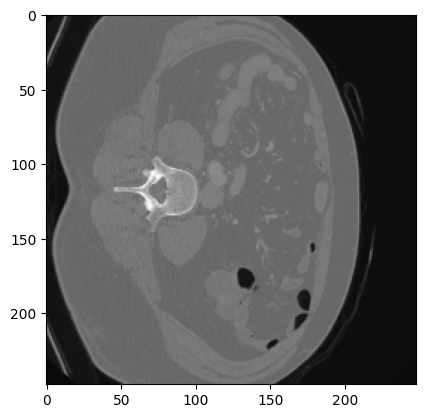

In [11]:
plt.imshow(img_tensor[0,0,:,:,75], cmap='gray');

In [12]:
img_tensor[:,:,:,:,70:75].shape

torch.Size([1, 1, 248, 248, 5])

In [13]:
weights_path = '/home/users/joecohen/scratch/logs-transformers/'
#weights_path = '/home/groups/akshaysc/joecohen/weights/'

#ae_folder = '2023-07-27T02-17-07_ct_vqgan_s'
#ae_folder = '2023-07-27T11-16-59_ct_vqgan_sd'
ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae = models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
)#.cuda()

Working with z of shape (1, 64, 16, 16) = 16384 dimensions.


/home/users/joecohen/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users/joecohen/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [14]:
x = img_tensor[:,:,:,:,75]

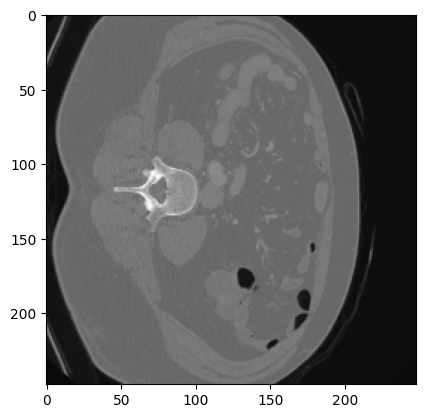

In [15]:
plt.imshow(x[0][0].detach().numpy(), cmap='gray');

In [16]:
z = ae.encode(x)

In [17]:
xp = ae.decode(z)

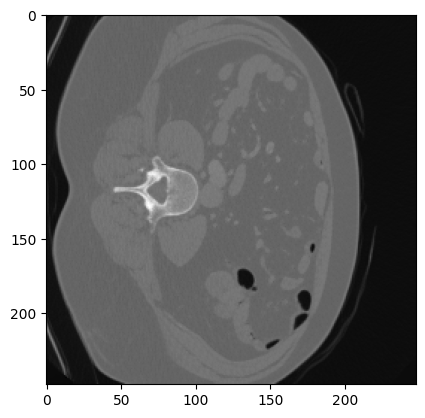

In [18]:
plt.imshow(xp[0][0].detach().numpy(), cmap='gray');

In [69]:
#xp.shape

In [18]:
#img_tensor[:,:,:,:,60:75], xp[...,None]

In [19]:
#img_tensor[:,:,:,:,60:75].shape

In [20]:
#zz = [ae.encode(img_tensor[:,:,:,:,i]) for i in range(70,80)]

In [21]:
#zz = torch.cat(zz)

In [65]:
#ae.encode(img_tensor[:,:,:,:,75]).shape

In [66]:
#img_tensor[:,:,:,:,75:77].transpose(-1,0)[...,0].shape

In [67]:
#xxp = ae.decode(ae.encode(img_tensor[:,:,:,:,75:77].transpose(-1,0)[...,0]))

In [68]:
#xxp[...,None].transpose(-1,0).shape

In [31]:
# class SliceAE:
#     def __init__(self):
#         self.ae = ae
        
#     def encode(self,x):
#         x = img_tensor[:,:,:,:,75]
#         z = self.ae.encode(x)
#         return z

#     def decode(self,z):
#         xp = ae.decode(z)
#         xx = torch.cat([img_tensor[:,:,:,:,:75], xp[...,None], img_tensor[:,:,:,:,76:]], 4)
#         return xx
    
# slice_ae = SliceAE()

In [19]:
class SliceAEFull:
    def __init__(self):
        self.ae = ae
        self.start = 60
        self.end = 100
        
    def encode(self,x):
        """Slice from the """
        zz = img_tensor[:,:,:,:,self.start:self.end].transpose(-1,0)[...,0]
        return self.ae.encode(zz)

    def decode(self,zz):
        xxp = ae.decode(zz)
        xx = torch.cat([img_tensor[:,:,:,:,:self.start], xxp[...,None].transpose(-1,0), img_tensor[:,:,:,:,self.end:]], 4)
        return xx
    
slice_ae = SliceAEFull()

In [70]:
#img_tensor.shape

In [21]:
#xxp = slice_ae.decode(slice_ae.encode(img_tensor))

In [22]:
#xxp.shape

In [23]:
#g = slice_ae.encode(img_tensor)

In [24]:
#slice_ae.decode(g).shape

In [25]:
# logit = model(img_tensor)
# print(torch.sigmoid(logit))

In [26]:
# logit = model(slice_ae.decode(slice_ae.encode(img_tensor)))
# print(torch.sigmoid(logit))

In [27]:
attr = captum.attr.LatentShift(model, slice_ae)
output = attr.attribute(x, target=0, 
                        fix_range=[-20000,0], 
                        #lambda_sweep_steps=3
                        return_dicts = True,
                        #apply_sigmoid = False,
                        #search_pred_diff = 50,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Selected bounds:  -20000 0
Lambdas to compute:  [-20000.         -17777.77777778 -15555.55555556 -13333.33333333
 -11111.11111111  -8888.88888889  -6666.66666667  -4444.44444444
  -2222.22222222      0.        ]


In [28]:
output['heatmap'].shape

(1, 248, 248, 150)

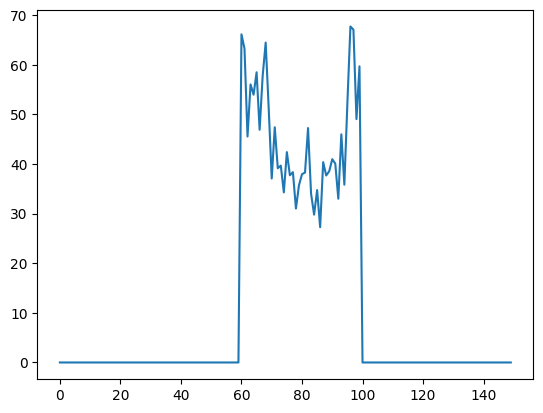

In [29]:
plt.plot(np.abs(output['heatmap']).sum(0).sum(0).sum(0))

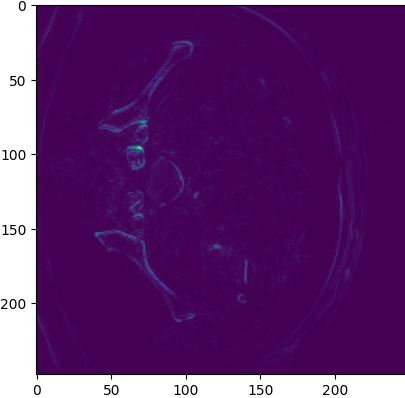

In [60]:
plt.imshow(output['heatmap'][0,:,:,61]);

In [50]:
output['preds']

[0.26987043023109436,
 0.2698666453361511,
 0.2699122726917267,
 0.27003151178359985,
 0.27028191089630127,
 0.2707914113998413,
 0.2715717554092407,
 0.27285683155059814,
 0.27512475848197937,
 0.279541552066803]

In [61]:
images = [output['generated_images'][i, :,:,:,61] for i in range(10)]

In [62]:
images[0].shape

(1, 248, 248)

In [63]:
video_utils.generate_video({"generated_images":images}, "test", show_pred=False, watermark=False, cmap='gray')


ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:248 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=       9kB time=00:00:00.76 bitrate=  97.0kbits/s speed=25.1x    


In [40]:
import os, psutil; print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


3417.45703125
